In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications
!pip install tensorflow-addons
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "timothymathew" # username from the json file
os.environ['KAGGLE_KEY'] = "bb0a99d9d8813ba5bed919ec080aa5cc" # key from the json file
!kaggle datasets download -d hgunraj/covidxct
!unzip -q "/content/covidxct.zip"

100% 28.7G/28.7G [04:42<00:00, 150MB/s]
100% 28.7G/28.7G [04:42<00:00, 109MB/s]


In [2]:
imagePathsAll = []
def load_labels(label_file):
    paths, labels = [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            path, label, xmin, ymin, xmax, ymax = line.strip('\n').split()
            paths.append(path)
            imagePathsAll.append(path)
            labels.append(int(label))
    return paths, labels

In [3]:
directory = '/content/2A_images/'
def process_images(paths, labels, bound):
  imageData = []
  boundedLabels = []
  imageCount = [0, 0, 0]
  imageDone = [False, False, False]
  for i in range(len(paths)):
    if (imageCount[labels[i]] < bound):
      imageCount[labels[i]] += 1
      if (len(imageData) % 10000 == 0):
        print(len(imageData))
      imgTensor = tf.image.decode_image(tf.io.read_file(directory + paths[i]))
      resizedImage = tf.image.resize(imgTensor, [224, 224], method='lanczos3')/255
      coloredImage = tf.image.grayscale_to_rgb(resizedImage)
      imageData.append(coloredImage)
      # imageData.append(directory + paths[i])
      boundedLabels.append(labels[i])
    else:
      imageDone[labels[i]] = True
      if (imageDone[0] and imageDone[1] and imageDone[2]):
        break
  return tf.convert_to_tensor(imageData), boundedLabels
  # return imageData, boundedLabels

In [4]:
trainPaths, trainLabels = load_labels('/content/train_COVIDx_CT-2A.txt')
valPaths, valLabels = load_labels('/content/val_COVIDx_CT-2A.txt')
testPaths, testLabels = load_labels('/content/test_COVIDx_CT-2A.txt')

# actual training: 25000, 10000, 3000
# test training: 3500, 500, 1000
trainData, trainLabels = process_images(trainPaths, trainLabels, 3500)
valData, valLabels = process_images(valPaths, valLabels, 500)
testData, testLabels = process_images(testPaths, testLabels, 1000)

trainLabels = tf.keras.utils.to_categorical(trainLabels)
valLabels = tf.keras.utils.to_categorical(valLabels)

0
0
0


In [ ]:
# creating datasets for radiologists
from PIL import Image
import random
arr = random.sample(range(150), 150)
for i in range(150):
  img = Image.open(testData[i])
  name = "ct_scan_" + str(arr[i]) + ".jpg"
  img = img.save(name)
  label = ""
  if (testLabels[i] == 0):
      label = "0 - Normal"
  elif (testLabels[i] == 1):
      label = "1 - Pneumonia"
  else:
      label = "2 - COVID-19"
  info = name + ": " + label
  print(info)

In [ ]:
# custom model (outdated severely)
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

In [5]:
vggModel = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(224, 224, 3))
# model = tf.keras.applications.resnet_v2.ResNet152V2(weights=None, input_shape=(128, 128, 1), classes=3)
# model = tf.keras.applications.densenet.DenseNet121(weights=None, input_shape=(128, 128, 1), classes=3)
# model = tf.keras.applications.efficientnet.EfficientNetB0(weights=None, input_shape=(128, 128, 1), classes=3)

In [ ]:
layer = vggModel.output
layer = layers.Flatten()(layer)
layer = layers.Dense(512, activation="relu")(layer)
layer = layers.Dropout(0.3)(layer)
layer = layers.Dense(128, activation="relu")(layer)
predictions = layers.Dense(3, activation="softmax")(layer)
model = models.Model(vggModel.input, predictions)

In [10]:
model.compile(optimizer='adamax',  
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', 
                       tf.keras.metrics.AUC(),
                       tfa.metrics.F1Score(3)])

In [ ]:
history = model.fit(trainData, trainLabels, epochs=4, validation_data=(valData, valLabels))

In [11]:
testPredictions = model.predict(testData)
testPredictionLabels = []
testAccuracy = 0
for i in range(len(testPredictions)):
  testPredictionLabels.append(np.argmax(testPredictions[i]))
  if (testPredictionLabels[i] == testLabels[i]):
    testAccuracy += 1
print(testAccuracy/len(testPredictionLabels))
confusion_mtx = tf.math.confusion_matrix(testLabels, testPredictionLabels, 3)
print(confusion_mtx)

0.5
tf.Tensor(
[[57  4 39]
 [ 9 86  5]
 [ 0 93  7]], shape=(3, 3), dtype=int32)


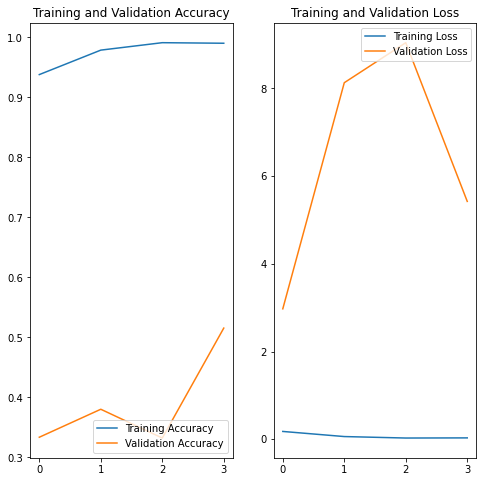

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
